In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

import music_tools
import importlib

Przygotowanie zbioru danych, adnotacji oraz cech

In [2]:
song_path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
print(song_path)
static_annotations_file = static_csv = os.path.join(song_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')
audio_path = os.path.join(song_path, 'DEAM_audio', 'MEMD_audio', )

C:\Users\Gabi\.cache\kagglehub\datasets\imsparsh\deam-mediaeval-dataset-emotional-analysis-in-music\versions\1


In [3]:
df = pd.read_csv(static_annotations_file)
df

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69
...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,2.21
1740,1997,5.3,1.42,3.9,1.14
1741,1998,6.4,1.50,6.2,1.60
1742,1999,4.6,2.11,5.4,1.80


In [4]:
conditions = [
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['happy', 'relaxed', 'sad', 'anger']
df['emotion'] = np.select(conditions, choices)
first = df.pop('emotion')
df.insert(1, 'emotion', first)
df

,song_id,emotion,valence_mean,valence_std,arousal_mean,arousal_std
0,2,sad,3.1,0.94,3.0,0.63
1,3,sad,3.5,1.75,3.3,1.62
2,4,happy,5.7,1.42,5.5,1.63
3,5,anger,4.4,2.01,5.3,1.85
4,7,happy,5.8,1.47,6.4,1.69
...,...,...,...,...,...,...
1739,1996,anger,3.9,1.87,5.9,2.21
1740,1997,relaxed,5.3,1.42,3.9,1.14
1741,1998,happy,6.4,1.50,6.2,1.60
1742,1999,anger,4.6,2.11,5.4,1.80


In [14]:
importlib.reload(music_tools)
music_tools.extract_features(f"{audio_path}/2.mp3")

{'rmse_mean': 0.105231434,
 'low_energy': 0.5051519835136528,
 'tempo_mean': 139.6748310810811,
 'spectral_centroid_mean': 1894.6842360126545,
 'spectral_entropy': 3.922585,
 'zcr_mean': 0.03652223000386399,
 'mfcc_mean_1': -200.25986,
 'mfcc_mean_2': 171.77264,
 'mfcc_mean_3': -32.70805,
 'mfcc_mean_4': 36.40345,
 'mfcc_mean_5': 0.23614448,
 'mfcc_mean_6': 17.683105,
 'mfcc_mean_7': 1.3651528,
 'mfcc_mean_8': 9.277338,
 'mfcc_mean_9': 1.3708614,
 'mfcc_mean_10': -3.2642543,
 'mfcc_mean_11': 6.4854536,
 'mfcc_mean_12': 1.0802174,
 'mfcc_mean_13': -1.0313374,
 'attack_time_mean': 10.832108843537414,
 'chroma_stft_mean_1': 0.40796068,
 'chroma_stft_mean_2': 0.3382784,
 'chroma_stft_mean_3': 0.30961463,
 'chroma_stft_mean_4': 0.37941808,
 'chroma_stft_mean_5': 0.55327046,
 'chroma_stft_mean_6': 0.57709205,
 'chroma_stft_mean_7': 0.46106908,
 'chroma_stft_mean_8': 0.47921777,
 'chroma_stft_mean_9': 0.59202737,
 'chroma_stft_mean_10': 0.69091535,
 'chroma_stft_mean_11': 0.55520093,
 'chroma

In [21]:
df_small = (df.groupby("emotion", group_keys=False)
            .apply(lambda x: x.sample(n=180, random_state=42), include_groups=False))
features_list = []
for i, song_id in enumerate(df_small['song_id']):
    extracted = music_tools.extract_features(f"{audio_path}/{song_id}.mp3")
    extracted['song_id'] = song_id
    features_list.append(extracted)
    print(f'{i} / {len(df_small)}')

features_df = pd.DataFrame(features_list)

C:\Users\Gabi\AppData\Local\Temp\ipykernel_24308\3250271454.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby("emotion", group_keys=False).apply(lambda x: x.sample(n=180, random_state=42))


0 / 720
1 / 720
2 / 720
3 / 720
4 / 720
5 / 720
6 / 720
7 / 720
8 / 720
9 / 720
10 / 720
11 / 720
12 / 720
13 / 720
14 / 720
15 / 720
16 / 720
17 / 720
18 / 720
19 / 720
20 / 720
21 / 720
22 / 720
23 / 720
24 / 720
25 / 720
26 / 720
27 / 720
28 / 720
29 / 720
30 / 720
31 / 720
32 / 720
33 / 720
34 / 720
35 / 720
36 / 720
37 / 720
38 / 720
39 / 720
40 / 720
41 / 720
42 / 720
43 / 720
44 / 720
45 / 720
46 / 720
47 / 720
48 / 720
49 / 720
50 / 720
51 / 720
52 / 720
53 / 720
54 / 720
55 / 720
56 / 720
57 / 720
58 / 720
59 / 720
60 / 720
61 / 720
62 / 720
63 / 720
64 / 720
65 / 720
66 / 720
67 / 720
68 / 720
69 / 720
70 / 720
71 / 720
72 / 720
73 / 720
74 / 720
75 / 720
76 / 720
77 / 720
78 / 720
79 / 720
80 / 720
81 / 720
82 / 720
83 / 720
84 / 720
85 / 720
86 / 720
87 / 720
88 / 720
89 / 720
90 / 720
91 / 720
92 / 720
93 / 720
94 / 720
95 / 720
96 / 720
97 / 720
98 / 720
99 / 720
100 / 720
101 / 720
102 / 720
103 / 720
104 / 720
105 / 720
106 / 720
107 / 720
108 / 720
109 / 720
110 / 720


In [22]:
df_small = df_small.merge(features_df, on="song_id", how="left")
df_small

,song_id,emotion,valence_mean,valence_std,arousal_mean,arousal_std,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,...,chroma_stft_mean_3,chroma_stft_mean_4,chroma_stft_mean_5,chroma_stft_mean_6,chroma_stft_mean_7,chroma_stft_mean_8,chroma_stft_mean_9,chroma_stft_mean_10,chroma_stft_mean_11,chroma_stft_mean_12
0,410,anger,3.8,1.99,5.1,1.70,0.054137,0.612056,79.507212,1441.616703,...,0.621955,0.582055,0.527333,0.508550,0.470440,0.621449,0.531169,0.456923,0.591773,0.626131
1,1493,anger,4.0,1.34,6.1,1.70,0.077924,0.476585,139.674831,5828.105637,...,0.315104,0.153796,0.131460,0.115143,0.113402,0.204006,0.510996,0.223181,0.133269,0.144826
2,686,anger,3.4,1.56,5.5,1.43,0.080775,0.533488,172.265625,1016.592086,...,0.344656,0.279488,0.318416,0.419631,0.518300,0.605562,0.478454,0.420210,0.337539,0.474641
3,1558,anger,3.4,1.56,5.9,1.14,0.079251,0.533024,161.499023,2982.515651,...,0.417346,0.390682,0.358740,0.567874,0.663325,0.475345,0.433052,0.513852,0.483531,0.522206
4,1227,anger,4.7,1.79,5.7,1.85,0.098690,0.476522,151.999081,2513.481396,...,0.489832,0.411314,0.479896,0.472020,0.485121,0.397238,0.444447,0.532585,0.447285,0.450058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1484,sad,4.4,1.36,3.8,1.40,0.066052,0.585736,166.708669,1610.443547,...,0.286121,0.313337,0.450747,0.386452,0.406966,0.526758,0.507180,0.496825,0.428689,0.446833
716,1741,sad,3.3,1.49,3.5,1.36,0.134870,0.480134,151.999081,539.396192,...,0.669498,0.702790,0.713175,0.617959,0.481375,0.448576,0.505525,0.544101,0.489325,0.515495
717,1244,sad,4.6,1.50,3.7,1.27,0.107301,0.506450,129.199219,1612.103503,...,0.493456,0.422342,0.483928,0.441750,0.564026,0.455918,0.459352,0.559435,0.469589,0.457602
718,1112,sad,3.1,1.45,2.3,1.27,0.043702,0.619979,82.031250,1743.380971,...,0.683386,0.450661,0.359311,0.315791,0.306898,0.352982,0.333332,0.387703,0.404307,0.354730


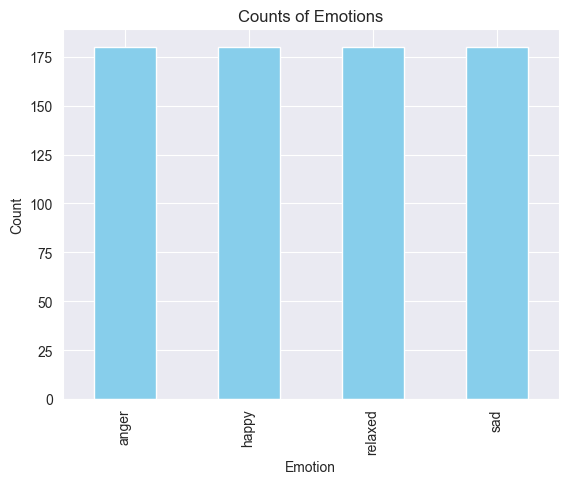

In [79]:
importlib.reload(music_tools)
music_tools.show_class_proportions(df_small['emotion'])

In [24]:
df_small.to_pickle('df_small.pkl')

In [78]:
df_small = pd.read_pickle('resources/df_small.pkl')
df_small

,song_id,emotion,valence_mean,valence_std,arousal_mean,arousal_std,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,...,chroma_stft_mean_3,chroma_stft_mean_4,chroma_stft_mean_5,chroma_stft_mean_6,chroma_stft_mean_7,chroma_stft_mean_8,chroma_stft_mean_9,chroma_stft_mean_10,chroma_stft_mean_11,chroma_stft_mean_12
0,410,anger,3.8,1.99,5.1,1.70,0.054137,0.612056,79.507212,1441.616703,...,0.621955,0.582055,0.527333,0.508550,0.470440,0.621449,0.531169,0.456923,0.591773,0.626131
1,1493,anger,4.0,1.34,6.1,1.70,0.077924,0.476585,139.674831,5828.105637,...,0.315104,0.153796,0.131460,0.115143,0.113402,0.204006,0.510996,0.223181,0.133269,0.144826
2,686,anger,3.4,1.56,5.5,1.43,0.080775,0.533488,172.265625,1016.592086,...,0.344656,0.279488,0.318416,0.419631,0.518300,0.605562,0.478454,0.420210,0.337539,0.474641
3,1558,anger,3.4,1.56,5.9,1.14,0.079251,0.533024,161.499023,2982.515651,...,0.417346,0.390682,0.358740,0.567874,0.663325,0.475345,0.433052,0.513852,0.483531,0.522206
4,1227,anger,4.7,1.79,5.7,1.85,0.098690,0.476522,151.999081,2513.481396,...,0.489832,0.411314,0.479896,0.472020,0.485121,0.397238,0.444447,0.532585,0.447285,0.450058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1484,sad,4.4,1.36,3.8,1.40,0.066052,0.585736,166.708669,1610.443547,...,0.286121,0.313337,0.450747,0.386452,0.406966,0.526758,0.507180,0.496825,0.428689,0.446833
716,1741,sad,3.3,1.49,3.5,1.36,0.134870,0.480134,151.999081,539.396192,...,0.669498,0.702790,0.713175,0.617959,0.481375,0.448576,0.505525,0.544101,0.489325,0.515495
717,1244,sad,4.6,1.50,3.7,1.27,0.107301,0.506450,129.199219,1612.103503,...,0.493456,0.422342,0.483928,0.441750,0.564026,0.455918,0.459352,0.559435,0.469589,0.457602
718,1112,sad,3.1,1.45,2.3,1.27,0.043702,0.619979,82.031250,1743.380971,...,0.683386,0.450661,0.359311,0.315791,0.306898,0.352982,0.333332,0.387703,0.404307,0.354730


In [19]:
df_small.sort_values(by=['song_id'], inplace=True)
X = df_small.drop(columns=['song_id', 'emotion', ' valence_mean', ' valence_std', ' arousal_mean', ' arousal_std'])
y = df_small['emotion']
X

,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,zcr_mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,...,chroma_stft_mean_3,chroma_stft_mean_4,chroma_stft_mean_5,chroma_stft_mean_6,chroma_stft_mean_7,chroma_stft_mean_8,chroma_stft_mean_9,chroma_stft_mean_10,chroma_stft_mean_11,chroma_stft_mean_12
95,0.149748,0.515339,123.046875,1898.303391,3.921232,0.036256,-190.341171,162.434845,-10.739488,38.936256,...,0.389788,0.470013,0.390246,0.360747,0.467110,0.267813,0.226276,0.222515,0.414721,0.551843
611,0.122685,0.552808,82.031250,1500.719439,2.873655,0.023845,-329.055511,141.721146,70.067329,59.842560,...,0.505253,0.592923,0.720757,0.624016,0.402677,0.391026,0.402190,0.451639,0.538464,0.579033
196,0.228288,0.459299,93.963068,2459.729178,3.738145,0.046425,-150.444061,142.376465,-6.482491,58.198883,...,0.515072,0.510753,0.480395,0.522896,0.476649,0.468333,0.406854,0.419095,0.447613,0.504718
173,0.210508,0.495106,107.666016,2125.983951,3.853783,0.039395,-139.417770,159.593918,-30.774439,48.519997,...,0.475304,0.393662,0.375995,0.446631,0.493522,0.595735,0.509300,0.481227,0.466717,0.416082
454,0.219194,0.625677,126.048018,1998.043201,4.429230,0.042700,-123.511635,182.557373,-18.492704,24.327259,...,0.529312,0.596610,0.553620,0.603684,0.415269,0.406719,0.553124,0.530664,0.609026,0.533563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.072612,0.487358,151.999081,2358.792142,5.377955,0.066299,-207.143448,164.896301,-55.259201,35.903008,...,0.410831,0.421979,0.474490,0.422537,0.481108,0.493160,0.454396,0.402774,0.440896,0.581378
161,0.089687,0.548246,92.285156,3690.651745,5.307375,0.096356,-141.017349,122.196404,-56.342869,61.072556,...,0.562976,0.515567,0.502378,0.505487,0.517392,0.545697,0.548861,0.564175,0.583653,0.658443
61,0.090230,0.485294,143.554688,2822.191477,5.460278,0.073798,-153.475174,158.476929,-66.439774,41.772823,...,0.498709,0.564256,0.623824,0.559037,0.476657,0.502964,0.637202,0.628726,0.489211,0.533891
701,0.113224,0.592688,143.554688,1418.705539,3.679795,0.024765,-223.448990,166.977142,-8.989333,29.319033,...,0.780164,0.633001,0.450240,0.380501,0.411692,0.398200,0.384095,0.453429,0.509366,0.530523


Klasyfikacja na poziomie całej piosenki na pomniejszonym zbiorze danych - po 180 przykładów każdej emocji (ze względu na bardzo długi czas obliczeń)

In [20]:
le = LabelEncoder()
y_en = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_en, test_size=0.2, random_state=42, stratify=y_en)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(576, 32)
(576,)
(144, 32)
(144,)


dla gotowych cech analogicznej metody było 48%

In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy:  0.5138888888888888
              precision    recall  f1-score   support

       anger       0.48      0.28      0.35        36
       happy       0.52      0.72      0.60        36
     relaxed       0.46      0.36      0.41        36
         sad       0.56      0.69      0.62        36

    accuracy                           0.51       144
   macro avg       0.50      0.51      0.49       144
weighted avg       0.50      0.51      0.49       144



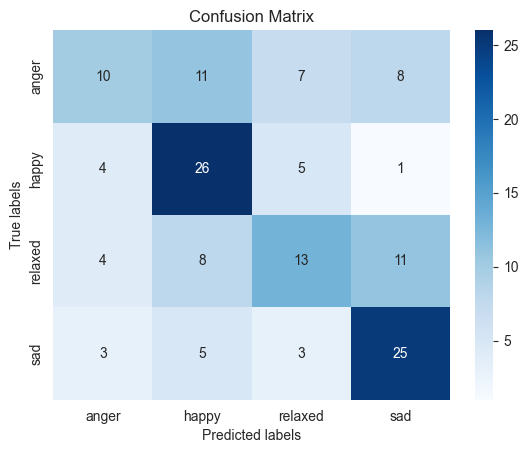

In [9]:
music_tools.show_classification_results(y_pred, y_test, le)

dla gotowych cech analogicznej metody było 42%

In [10]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Accuracy:  0.5
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        36
       happy       0.50      0.78      0.61        36
     relaxed       0.40      0.50      0.44        36
         sad       0.60      0.72      0.66        36

    accuracy                           0.50       144
   macro avg       0.38      0.50      0.43       144
weighted avg       0.38      0.50      0.43       144



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

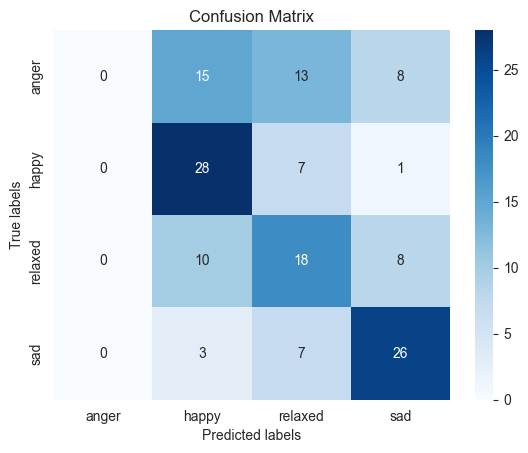

In [11]:
music_tools.show_classification_results(y_pred, y_test, le)

dla gotowych cech analogicznej metody było 46%

In [36]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

KeyboardInterrupt: 

Accuracy:  0.4583333333333333
              precision    recall  f1-score   support

       anger       0.32      0.33      0.32        36
       happy       0.49      0.67      0.56        36
     relaxed       0.37      0.28      0.32        36
         sad       0.67      0.56      0.61        36

    accuracy                           0.46       144
   macro avg       0.46      0.46      0.45       144
weighted avg       0.46      0.46      0.45       144



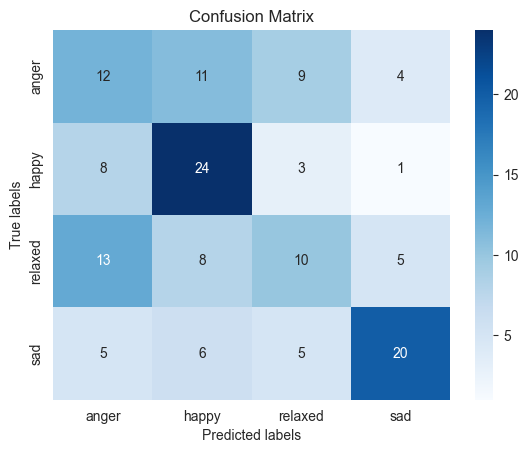

In [59]:
music_tools.show_classification_results(y_pred, y_test, le)

dla gotowych cech analogicznej metody było 48%

Accuracy:  0.5069444444444444
              precision    recall  f1-score   support

       anger       0.33      0.14      0.20        36
       happy       0.48      0.81      0.60        36
     relaxed       0.42      0.31      0.35        36
         sad       0.65      0.78      0.71        36

    accuracy                           0.51       144
   macro avg       0.47      0.51      0.47       144
weighted avg       0.47      0.51      0.47       144



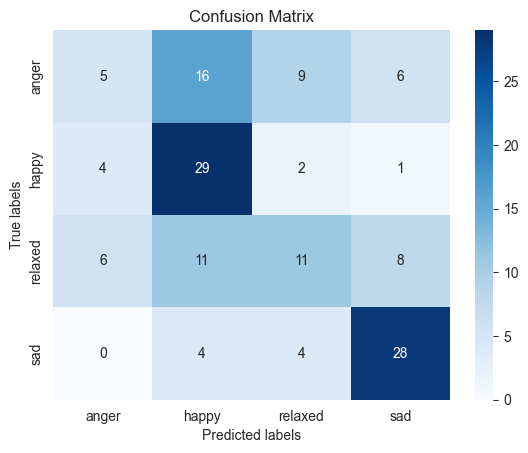

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.base import BaseEstimator, ClassifierMixin, clone


class MedianVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers):
        self.classifiers = classifiers

    def fit(self, X, y):
        self.models_ = [clone(clf).fit(X, y) for clf in self.classifiers]
        return self

    def predict(self, X):
        all_preds = np.asarray([model.predict(X) for model in self.models_])
        return np.median(all_preds, axis=0).round().astype(int)  # zakłada klasy 0,1,2,...

# Przygotuj modele
models = [
    SVC(C=0.5, kernel='linear', probability=False),
    NearestCentroid(),
    KNeighborsClassifier(n_neighbors=200),
    GaussianNB(),
    LinearDiscriminantAnalysis()
]

# Klasyfikator głosujący
voter = MedianVotingClassifier(models)
voter.fit(X_train, y_train)
y_pred = voter.predict(X_test)

music_tools.show_classification_results(y_pred, y_test, le)

In [37]:
num_classes = 4
input_shape = (X_train.shape[1],)

model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,044 (27.52 KB)

 Trainable params: 6,788 (26.52 KB)

 Non-trainable params: 256 (1.00 KB)

In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3648 - loss: 1.5514 - val_accuracy: 0.2917 - val_loss: 1.9397
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3499 - loss: 1.5704 - val_accuracy: 0.2639 - val_loss: 1.5757
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3805 - loss: 1.5225 - val_accuracy: 0.2708 - val_loss: 1.4381
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3634 - loss: 1.5014 - val_accuracy: 0.3403 - val_loss: 1.2950
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3504 - loss: 1.4221 - val_accuracy: 0.3889 - val_loss: 1.2786
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4018 - loss: 1.3874 - val_accuracy: 0.4236 - val_loss: 1.2697
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4063 - loss: 1.4384 - val_accuracy: 0.4167 - val_loss: 1.2536
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3778 - loss: 1.3432 - val_accuracy: 0.4236 - 

Accuracy:  0.4652777777777778
              precision    recall  f1-score   support

       anger       0.50      0.17      0.25        36
       happy       0.49      0.56      0.52        36
     relaxed       0.33      0.36      0.35        36
         sad       0.54      0.78      0.64        36

    accuracy                           0.47       144
   macro avg       0.46      0.47      0.44       144
weighted avg       0.46      0.47      0.44       144



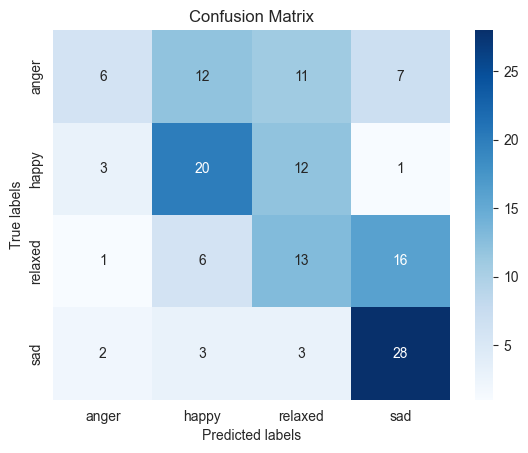

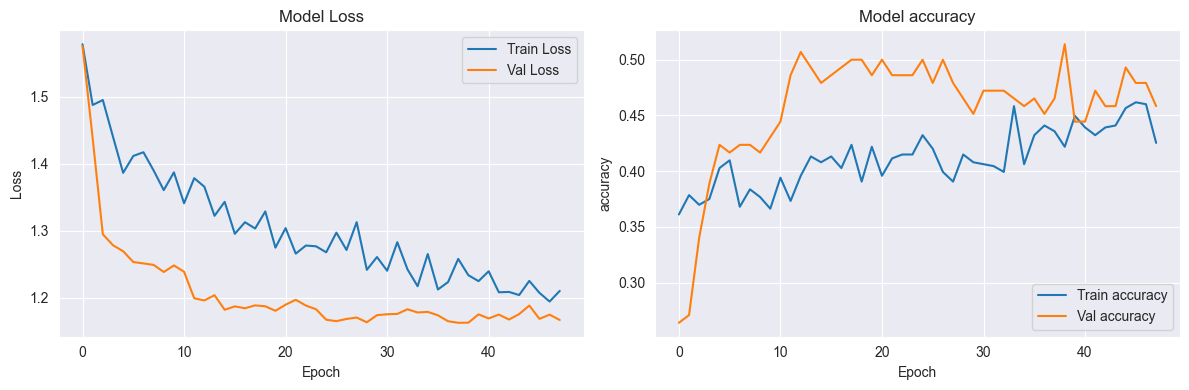

In [41]:
music_tools.show_classification_results(y_pred, y_test, le)
music_tools.plot_trainig_history(history)

In [33]:
num_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1],)

model = Sequential([
    Dense(128, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,508 (52.77 KB)

 Trainable params: 13,124 (51.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2545 - loss: 1.7870 - val_accuracy: 0.2778 - val_loss: 2.8456
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3158 - loss: 1.6188 - val_accuracy: 0.3194 - val_loss: 2.1375
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3243 - loss: 1.5279 - val_accuracy: 0.3819 - val_loss: 1.5506
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3519 - loss: 1.4059 - val_accuracy: 0.4444 - val_loss: 1.5144
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3206 - loss: 1.4241 - val_accuracy: 0.4236 - val_loss: 1.4316
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4040 - loss: 1.4295 - val_accuracy: 0.4514 - val_loss: 1.3322
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3890 - loss: 1.3876 - val_accuracy: 0.4375 - val_loss: 1.2632
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3927 - loss: 1.3737 - val_accuracy: 0.4861 -

Accuracy:  0.5347222222222222
              precision    recall  f1-score   support

       anger       0.46      0.17      0.24        36
       happy       0.53      0.78      0.63        36
     relaxed       0.49      0.50      0.49        36
         sad       0.61      0.69      0.65        36

    accuracy                           0.53       144
   macro avg       0.52      0.53      0.50       144
weighted avg       0.52      0.53      0.50       144



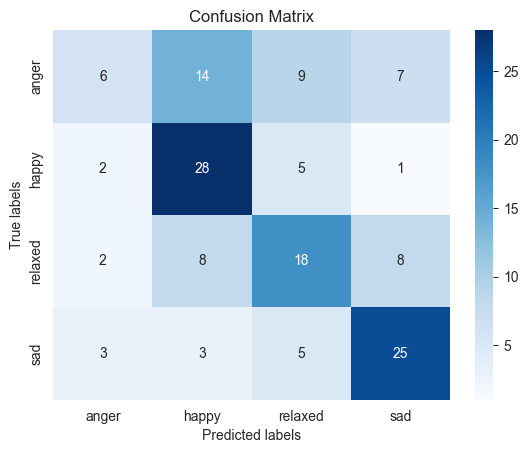

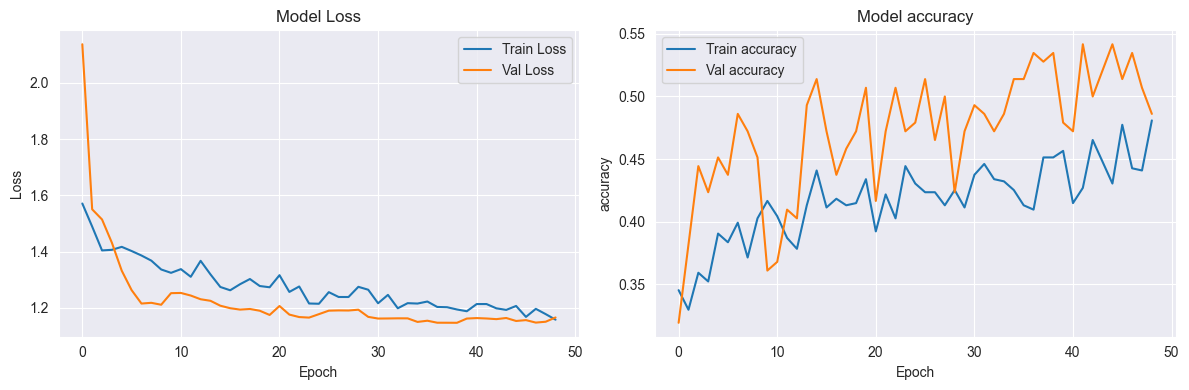

In [35]:
music_tools.show_classification_results(y_pred, y_test, le)
music_tools.plot_trainig_history(history)

Adnotacje dynamiczne - na segmentach utworów

In [45]:
song_path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
arousal_file = static_csv = os.path.join(song_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'dynamic (per second annotations)',
                          'arousal.csv')
valence_file = os.path.join(song_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'dynamic (per second annotations)',
                          'valence.csv')
audio_path = os.path.join(song_path, 'DEAM_audio', 'MEMD_audio', )

Stworzenie ramki z valence i arousal dla każdego okna w utworach

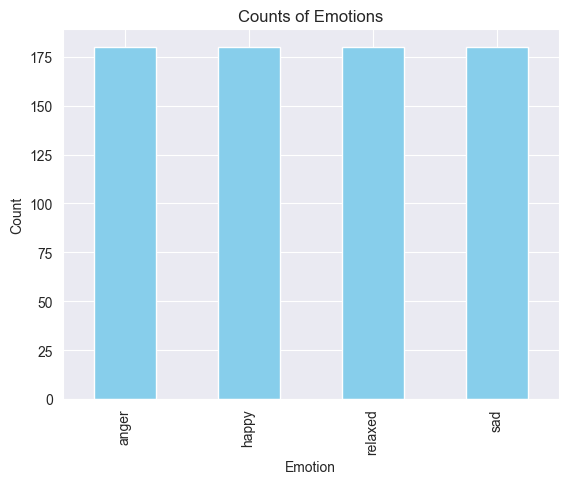

In [82]:
# importlib.reload(music_tools)
# df_small = (df.groupby("emotion", group_keys=False)
#             .apply(lambda x: x.sample(n=180, random_state=42), include_groups=False))
music_tools.show_class_proportions(df_small["emotion"])

In [18]:
importlib.reload(music_tools)
df_small = (df.groupby("emotion", group_keys=False)
            .apply(lambda x: x.sample(n=180, random_state=42), include_groups=False))
all_features = []
for i, song_id in enumerate(df_small.song_id.to_list()):
    path = os.path.join(audio_path, f"{song_id}.mp3")
    features_df = music_tools.extract_features_segmented(path, song_id, frame_duration=5)
    all_features.append(features_df)
    print(f"{i} / {len(df_small.song_id)}")
df_segments = pd.concat(all_features, ignore_index=True)
df_segments.tempo_mean = df_segments.tempo_mean.astype(float)
df_segments

0 / 720
1 / 720
2 / 720
3 / 720
4 / 720
5 / 720
6 / 720
7 / 720
8 / 720
9 / 720
10 / 720
11 / 720
12 / 720
13 / 720
14 / 720
15 / 720
16 / 720
17 / 720
18 / 720
19 / 720
20 / 720
21 / 720
22 / 720
23 / 720
24 / 720
25 / 720
26 / 720
27 / 720
28 / 720
29 / 720
30 / 720
31 / 720
32 / 720
33 / 720
34 / 720
35 / 720
36 / 720
37 / 720
38 / 720
39 / 720
40 / 720
41 / 720
42 / 720
43 / 720
44 / 720
45 / 720
46 / 720
47 / 720
48 / 720
49 / 720
50 / 720
51 / 720
52 / 720
53 / 720
54 / 720
55 / 720
56 / 720
57 / 720
58 / 720
59 / 720
60 / 720
61 / 720
62 / 720
63 / 720
64 / 720
65 / 720
66 / 720
67 / 720
68 / 720
69 / 720
70 / 720
71 / 720
72 / 720
73 / 720
74 / 720
75 / 720
76 / 720
77 / 720
78 / 720
79 / 720
80 / 720
81 / 720
82 / 720
83 / 720
84 / 720
85 / 720
86 / 720
87 / 720
88 / 720
89 / 720
90 / 720
91 / 720
92 / 720
93 / 720
94 / 720
95 / 720
96 / 720
97 / 720
98 / 720
99 / 720
100 / 720
101 / 720
102 / 720
103 / 720
104 / 720
105 / 720
106 / 720
107 / 720
108 / 720
109 / 720
110 / 720


,song_id,second,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,zcr_mean,attack_time_mean,mfcc_mean_1,...,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12
0,410,0,0.027820,0.568445,[161.4990234375],1446.401082,4.766673,0.048475,11.981497,-353.126241,...,0.384197,0.449891,0.428387,0.518040,0.487513,0.624729,0.541874,0.388185,0.587749,0.474378
1,410,220500,0.028275,0.651972,[80.74951171875],1062.454456,4.237439,0.032196,11.981497,-373.815111,...,0.653656,0.419936,0.279624,0.207304,0.211839,0.474189,0.360274,0.245852,0.323010,0.416972
2,410,441000,0.028568,0.712297,[78.30255681818181],1109.475302,4.247305,0.034348,11.981497,-361.681728,...,0.554703,0.333499,0.271405,0.232500,0.285196,0.566902,0.325747,0.224681,0.273165,0.507433
3,410,661500,0.025944,0.628770,[161.4990234375],1111.699238,4.384062,0.030853,11.981497,-363.839534,...,0.520162,0.581901,0.523419,0.453257,0.403774,0.599393,0.426415,0.340778,0.580908,0.465846
4,410,882000,0.036277,0.640371,[79.50721153846153],1410.636309,4.491467,0.039155,11.981497,-320.635134,...,0.431383,0.497448,0.491362,0.526622,0.516807,0.670010,0.547421,0.419743,0.612899,0.507683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1790,220500,0.050285,0.570766,[54.39967105263158],1089.798436,3.972366,0.038691,9.427302,-342.844836,...,0.401327,0.520838,0.539407,0.344893,0.290688,0.285653,0.166690,0.149079,0.178591,0.207091
4312,1790,441000,0.042473,0.654292,[147.65625],886.503727,2.804191,0.030367,9.427302,-401.931410,...,0.222979,0.246689,0.277828,0.258112,0.496931,0.222075,0.043850,0.026722,0.036297,0.086446
4313,1790,661500,0.017138,0.668213,[172.265625],821.248140,3.110637,0.027829,9.427302,-489.973613,...,0.217677,0.179447,0.221607,0.182508,0.139566,0.143450,0.205827,0.277599,0.422402,0.373031
4314,1790,882000,0.035891,0.605568,[161.4990234375],841.684479,2.719130,0.032182,9.427302,-454.814700,...,0.144364,0.270391,0.269800,0.416053,0.280979,0.292497,0.234716,0.136882,0.109681,0.059643


In [42]:
df_segments.to_pickle("df_segments.pkl")

In [157]:
df_segments = pd.read_pickle("resources/df_segments.pkl")
df_segments

,song_id,second,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,zcr_mean,attack_time_mean,mfcc_mean_1,...,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12
0,410,15,0.027820,0.568445,161.499023,1446.401082,4.766673,0.048475,11.981497,-353.126241,...,0.384197,0.449891,0.428387,0.518040,0.487513,0.624729,0.541874,0.388185,0.587749,0.474378
1,410,20,0.028275,0.651972,80.749512,1062.454456,4.237439,0.032196,11.981497,-373.815111,...,0.653656,0.419936,0.279624,0.207304,0.211839,0.474189,0.360274,0.245852,0.323010,0.416972
2,410,25,0.028568,0.712297,78.302557,1109.475302,4.247305,0.034348,11.981497,-361.681728,...,0.554703,0.333499,0.271405,0.232500,0.285196,0.566902,0.325747,0.224681,0.273165,0.507433
3,410,30,0.025944,0.628770,161.499023,1111.699238,4.384062,0.030853,11.981497,-363.839534,...,0.520162,0.581901,0.523419,0.453257,0.403774,0.599393,0.426415,0.340778,0.580908,0.465846
4,410,35,0.036277,0.640371,79.507212,1410.636309,4.491467,0.039155,11.981497,-320.635134,...,0.431383,0.497448,0.491362,0.526622,0.516807,0.670010,0.547421,0.419743,0.612899,0.507683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1790,20,0.050285,0.570766,54.399671,1089.798436,3.972366,0.038691,9.427302,-342.844836,...,0.401327,0.520838,0.539407,0.344893,0.290688,0.285653,0.166690,0.149079,0.178591,0.207091
4312,1790,25,0.042473,0.654292,147.656250,886.503727,2.804191,0.030367,9.427302,-401.931410,...,0.222979,0.246689,0.277828,0.258112,0.496931,0.222075,0.043850,0.026722,0.036297,0.086446
4313,1790,30,0.017138,0.668213,172.265625,821.248140,3.110637,0.027829,9.427302,-489.973613,...,0.217677,0.179447,0.221607,0.182508,0.139566,0.143450,0.205827,0.277599,0.422402,0.373031
4314,1790,35,0.035891,0.605568,161.499023,841.684479,2.719130,0.032182,9.427302,-454.814700,...,0.144364,0.270391,0.269800,0.416053,0.280979,0.292497,0.234716,0.136882,0.109681,0.059643


In [158]:
valence = pd.read_csv(valence_file, delimiter=',').set_index('song_id')
arousal = pd.read_csv(arousal_file, delimiter=',').set_index('song_id')
frame_duration = 5

valence_labels = []
arousal_labels = []

for idx, row in df_segments.iterrows():
    song_id = row["song_id"]
    t = row["second"] * 1000
    frame_duration = 5000

    valence_row = valence.loc[song_id]
    arousal_row = arousal.loc[song_id]

    v_list, a_list = [], []
    for i in np.arange(0, frame_duration, 500):
        col = f"sample_{int(t+i)}ms"
        if col in valence_row.index:
            v_list.append(valence_row[col])
            a_list.append(arousal_row[col])

    if v_list and a_list:
        valence_labels.append(np.mean(v_list))
        arousal_labels.append(np.mean(a_list))
    else:
        valence_labels.append(np.nan)
        arousal_labels.append(np.nan)

df_segments["valence"] = valence_labels
df_segments["arousal"] = arousal_labels
df_segments

,song_id,second,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,zcr_mean,attack_time_mean,mfcc_mean_1,...,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12,valence,arousal
0,410,15,0.027820,0.568445,161.499023,1446.401082,4.766673,0.048475,11.981497,-353.126241,...,0.428387,0.518040,0.487513,0.624729,0.541874,0.388185,0.587749,0.474378,-0.064225,-0.424042
1,410,20,0.028275,0.651972,80.749512,1062.454456,4.237439,0.032196,11.981497,-373.815111,...,0.279624,0.207304,0.211839,0.474189,0.360274,0.245852,0.323010,0.416972,-0.055429,-0.434814
2,410,25,0.028568,0.712297,78.302557,1109.475302,4.247305,0.034348,11.981497,-361.681728,...,0.271405,0.232500,0.285196,0.566902,0.325747,0.224681,0.273165,0.507433,-0.026115,-0.439597
3,410,30,0.025944,0.628770,161.499023,1111.699238,4.384062,0.030853,11.981497,-363.839534,...,0.523419,0.453257,0.403774,0.599393,0.426415,0.340778,0.580908,0.465846,-0.015767,-0.439842
4,410,35,0.036277,0.640371,79.507212,1410.636309,4.491467,0.039155,11.981497,-320.635134,...,0.491362,0.526622,0.516807,0.670010,0.547421,0.419743,0.612899,0.507683,-0.018685,-0.445488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1790,20,0.050285,0.570766,54.399671,1089.798436,3.972366,0.038691,9.427302,-342.844836,...,0.539407,0.344893,0.290688,0.285653,0.166690,0.149079,0.178591,0.207091,-0.114100,0.067800
4312,1790,25,0.042473,0.654292,147.656250,886.503727,2.804191,0.030367,9.427302,-401.931410,...,0.277828,0.258112,0.496931,0.222075,0.043850,0.026722,0.036297,0.086446,-0.182800,-0.018000
4313,1790,30,0.017138,0.668213,172.265625,821.248140,3.110637,0.027829,9.427302,-489.973613,...,0.221607,0.182508,0.139566,0.143450,0.205827,0.277599,0.422402,0.373031,-0.280300,-0.085500
4314,1790,35,0.035891,0.605568,161.499023,841.684479,2.719130,0.032182,9.427302,-454.814700,...,0.269800,0.416053,0.280979,0.292497,0.234716,0.136882,0.109681,0.059643,-0.268900,-0.110100


In [159]:
conditions = [
    (df_segments['valence'] > 0) & (df_segments['arousal'] > 0),
    (df_segments['valence'] > 0) & (df_segments['arousal'] < 0),
    (df_segments['valence'] < 0) & (df_segments['arousal'] < 0),
    (df_segments['valence'] < 0) & (df_segments['arousal'] > 0)
]
choices = ['happy', 'relaxed', 'sad', 'angry']
df_segments['emotion'] = np.select(conditions, choices, default=None)

emotion = df_segments.pop('emotion')
df_segments.insert(2, 'emotion', emotion)

valence = df_segments.pop('valence')
df_segments.insert(2, 'valence', valence)

arousal = df_segments.pop('arousal')
df_segments.insert(2, 'arousal', arousal)

df_segments

,song_id,second,arousal,valence,emotion,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,...,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12
0,410,15,-0.424042,-0.064225,sad,0.027820,0.568445,161.499023,1446.401082,4.766673,...,0.384197,0.449891,0.428387,0.518040,0.487513,0.624729,0.541874,0.388185,0.587749,0.474378
1,410,20,-0.434814,-0.055429,sad,0.028275,0.651972,80.749512,1062.454456,4.237439,...,0.653656,0.419936,0.279624,0.207304,0.211839,0.474189,0.360274,0.245852,0.323010,0.416972
2,410,25,-0.439597,-0.026115,sad,0.028568,0.712297,78.302557,1109.475302,4.247305,...,0.554703,0.333499,0.271405,0.232500,0.285196,0.566902,0.325747,0.224681,0.273165,0.507433
3,410,30,-0.439842,-0.015767,sad,0.025944,0.628770,161.499023,1111.699238,4.384062,...,0.520162,0.581901,0.523419,0.453257,0.403774,0.599393,0.426415,0.340778,0.580908,0.465846
4,410,35,-0.445488,-0.018685,sad,0.036277,0.640371,79.507212,1410.636309,4.491467,...,0.431383,0.497448,0.491362,0.526622,0.516807,0.670010,0.547421,0.419743,0.612899,0.507683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1790,20,0.067800,-0.114100,angry,0.050285,0.570766,54.399671,1089.798436,3.972366,...,0.401327,0.520838,0.539407,0.344893,0.290688,0.285653,0.166690,0.149079,0.178591,0.207091
4312,1790,25,-0.018000,-0.182800,sad,0.042473,0.654292,147.656250,886.503727,2.804191,...,0.222979,0.246689,0.277828,0.258112,0.496931,0.222075,0.043850,0.026722,0.036297,0.086446
4313,1790,30,-0.085500,-0.280300,sad,0.017138,0.668213,172.265625,821.248140,3.110637,...,0.217677,0.179447,0.221607,0.182508,0.139566,0.143450,0.205827,0.277599,0.422402,0.373031
4314,1790,35,-0.110100,-0.268900,sad,0.035891,0.605568,161.499023,841.684479,2.719130,...,0.144364,0.270391,0.269800,0.416053,0.280979,0.292497,0.234716,0.136882,0.109681,0.059643


In [160]:
to_remove = df_segments.loc[df_segments['emotion'] == 'happy'][:1650]['song_id'].unique()
df_segments = df_segments[~df_segments['song_id'].isin(to_remove)]
df_segments

,song_id,second,arousal,valence,emotion,rmse_mean,low_energy,tempo_mean,spectral_centroid_mean,spectral_entropy,...,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_mean_12
0,410,15,-0.424042,-0.064225,sad,0.027820,0.568445,161.499023,1446.401082,4.766673,...,0.384197,0.449891,0.428387,0.518040,0.487513,0.624729,0.541874,0.388185,0.587749,0.474378
1,410,20,-0.434814,-0.055429,sad,0.028275,0.651972,80.749512,1062.454456,4.237439,...,0.653656,0.419936,0.279624,0.207304,0.211839,0.474189,0.360274,0.245852,0.323010,0.416972
2,410,25,-0.439597,-0.026115,sad,0.028568,0.712297,78.302557,1109.475302,4.247305,...,0.554703,0.333499,0.271405,0.232500,0.285196,0.566902,0.325747,0.224681,0.273165,0.507433
3,410,30,-0.439842,-0.015767,sad,0.025944,0.628770,161.499023,1111.699238,4.384062,...,0.520162,0.581901,0.523419,0.453257,0.403774,0.599393,0.426415,0.340778,0.580908,0.465846
4,410,35,-0.445488,-0.018685,sad,0.036277,0.640371,79.507212,1410.636309,4.491467,...,0.431383,0.497448,0.491362,0.526622,0.516807,0.670010,0.547421,0.419743,0.612899,0.507683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,1790,20,0.067800,-0.114100,angry,0.050285,0.570766,54.399671,1089.798436,3.972366,...,0.401327,0.520838,0.539407,0.344893,0.290688,0.285653,0.166690,0.149079,0.178591,0.207091
4312,1790,25,-0.018000,-0.182800,sad,0.042473,0.654292,147.656250,886.503727,2.804191,...,0.222979,0.246689,0.277828,0.258112,0.496931,0.222075,0.043850,0.026722,0.036297,0.086446
4313,1790,30,-0.085500,-0.280300,sad,0.017138,0.668213,172.265625,821.248140,3.110637,...,0.217677,0.179447,0.221607,0.182508,0.139566,0.143450,0.205827,0.277599,0.422402,0.373031
4314,1790,35,-0.110100,-0.268900,sad,0.035891,0.605568,161.499023,841.684479,2.719130,...,0.144364,0.270391,0.269800,0.416053,0.280979,0.292497,0.234716,0.136882,0.109681,0.059643


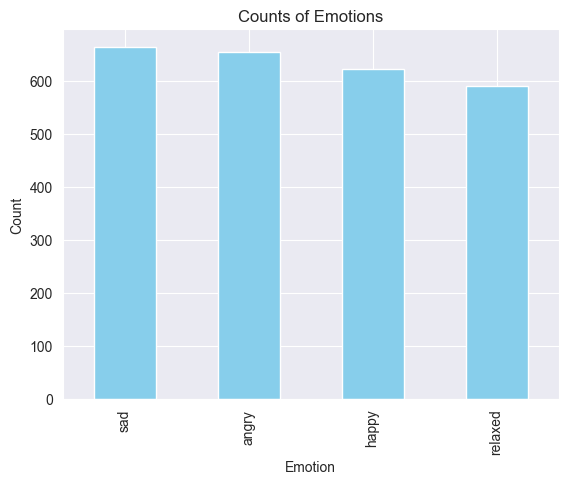

In [161]:
music_tools.show_class_proportions(df_segments['emotion'])

In [162]:
song_ids = list(df_segments.song_id.unique())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

X_train = df_segments.loc[df_segments['song_id'].isin(train_ids)].drop(['song_id', 'second', 'emotion', 'arousal', 'valence'], axis=1)
X_test = df_segments.loc[df_segments['song_id'].isin(test_ids)].drop(['song_id', 'second', 'emotion', 'arousal', 'valence'], axis=1)

y_train = df_segments.loc[df_segments['song_id'].isin(train_ids)][['arousal', 'valence']]
y_train_emotion = df_segments.loc[df_segments['song_id'].isin(train_ids)][['emotion']]

y_test = df_segments.loc[df_segments['song_id'].isin(test_ids)][['arousal', 'valence']]
y_test_emotion = df_segments.loc[df_segments['song_id'].isin(test_ids)][['emotion']]

print(X_train.shape)
print(y_train.shape)
print(y_train_emotion.shape)

print(X_test.shape)
print(y_test.shape)
print(y_test_emotion.shape)

(2022, 32)
(2022, 2)
(2022, 1)
(510, 32)
(510, 2)
(510, 1)


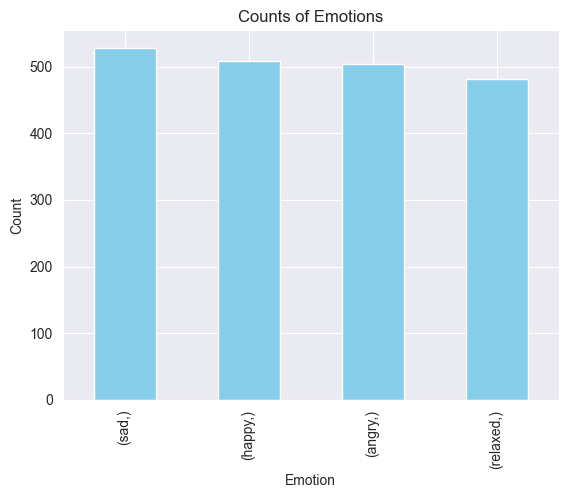

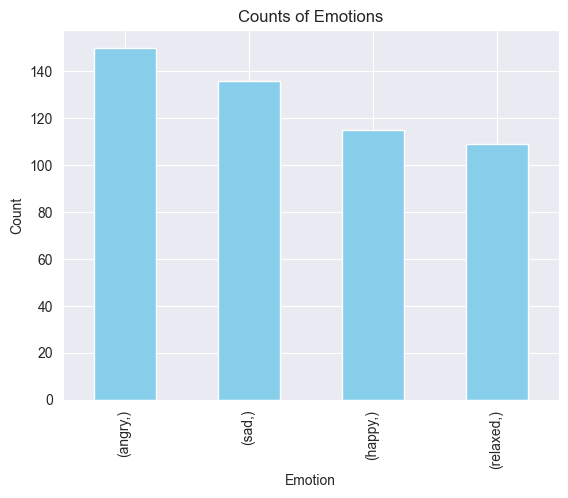

In [163]:
music_tools.show_class_proportions(y_train_emotion)
music_tools.show_class_proportions(y_test_emotion)

In [164]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_shape = X_train.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),

    Dense(2, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,394 (60.13 KB)

 Trainable params: 15,010 (58.63 KB)

 Non-trainable params: 384 (1.50 KB)

In [166]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=32)

y_pred = model.predict(X_test)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0762 - mae: 0.7860 - val_loss: 0.0936 - val_mae: 0.2439
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3652 - mae: 0.4713 - val_loss: 0.0978 - val_mae: 0.2513
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2354 - mae: 0.3785 - val_loss: 0.1030 - val_mae: 0.2601
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1680 - mae: 0.3230 - val_loss: 0.0984 - val_mae: 0.2530
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1484 - mae: 0.3020 - val_loss: 0.0925 - val_mae: 0.2453
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1214 - mae: 0.2723 - val_loss: 0.0856 - val_mae: 0.2383
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1047 - mae: 0.2553 - val_loss: 0.0780 - val_mae: 0.2284
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0899 - mae: 0.2366 - val_loss: 0.0776 - val_mae: 0.2261
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886 - mae: 

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0490
MSE Arousal: 0.0496
-------------------------------------
MAE Valence: 0.1765
MAE Arousal: 0.1899
-------------------------------------
R² Valence: -0.0425
R² Arousal: 0.3047
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       angry       0.77      0.55      0.64       150
       happy       0.30      0.42      0.35       115
     relaxed       0.27      0.44      0.34       109
         sad       0.59      0.27      0.37       136

    accuracy                           0.42       510
   macro avg       0.48      0.42      0.42       510
weighted avg       0.51      0.42      0.44       510



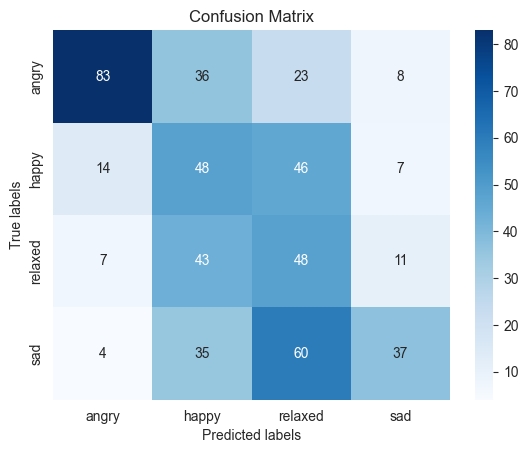

In [167]:
importlib.reload(music_tools)
music_tools.evaluate_regression_model(y_test, y_test_emotion, y_pred)

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0452
MSE Arousal: 0.0416
-------------------------------------
MAE Valence: 0.1700
MAE Arousal: 0.1681
-------------------------------------
R² Valence: 0.0376
R² Arousal: 0.4172
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       angry       0.76      0.67      0.71       150
       happy       0.31      0.44      0.37       115
     relaxed       0.29      0.34      0.31       109
         sad       0.52      0.34      0.41       136

    accuracy                           0.46       510
   macro avg       0.47      0.45      0.45       510
weighted avg       0.50      0.46      0.47       510



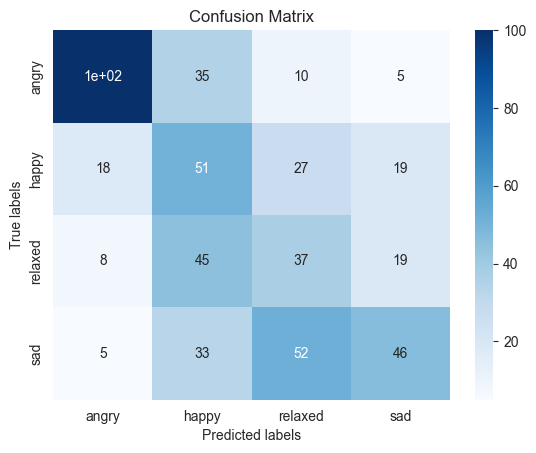

In [175]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=600, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

music_tools.evaluate_regression_model(y_test, y_test_emotion, y_pred)

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0493
MSE Arousal: 0.0390
-------------------------------------
MAE Valence: 0.1777
MAE Arousal: 0.1607
-------------------------------------
R² Valence: -0.0492
R² Arousal: 0.4531
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       angry       0.72      0.63      0.67       150
       happy       0.32      0.47      0.38       115
     relaxed       0.34      0.39      0.36       109
         sad       0.53      0.35      0.42       136

    accuracy                           0.46       510
   macro avg       0.48      0.46      0.46       510
weighted avg       0.50      0.46      0.47       510



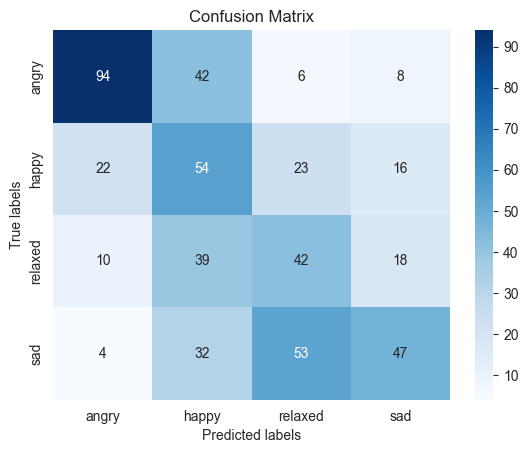

In [176]:
from xgboost import XGBRegressor

reg = XGBRegressor(
    n_estimators=1500, max_depth=6, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, tree_method="hist", random_state=42
)
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)
y_pred = reg.predict(X_test)

music_tools.evaluate_regression_model(y_test, y_test_emotion, y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0451
MSE Arousal: 0.0459
-------------------------------------
MAE Valence: 0.1724
MAE Arousal: 0.1774
-------------------------------------
R² Valence: 0.0395
R² Arousal: 0.3566
-------------------------------------
CLASSIFICATION ACCURACY

              precision    recall  f1-score   support

       angry       0.69      0.63      0.66       150
       happy       0.24      0.28      0.26       115
     relaxed       0.33      0.35      0.34       109
         sad       0.44      0.40      0.42       136

    accuracy                           0.43       510
   macro avg       0.42      0.41      0.42       510
weighted avg       0.44      0.43      0.44       510



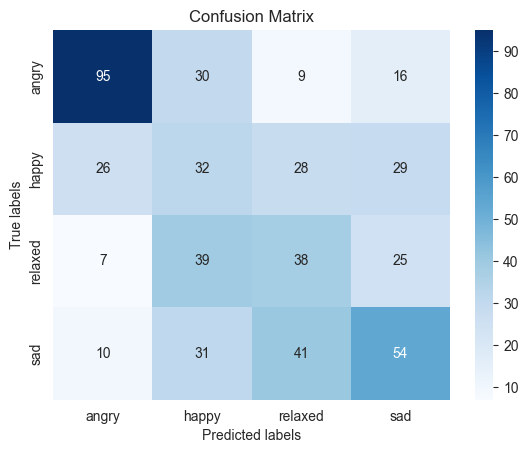

In [178]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, models

inp = layers.Input(shape=(X_train.shape[1],))
x = layers.LayerNormalization()(inp)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(2, activation='linear')(x)

nn = models.Model(inp, out)
nn.compile(optimizer=optimizers.Adam(1e-3), loss=tf.keras.losses.Huber(), metrics=['mae'])

es = callbacks.EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=7, min_lr=1e-5)

hist = nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200, batch_size=64,
    callbacks=[es, rlr],
    verbose=0
)

y_pred = nn.predict(X_test)
music_tools.evaluate_regression_model(y_test, y_test_emotion, y_pred)

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

       angry       0.77      0.62      0.69       150
       happy       0.35      0.50      0.41       115
     relaxed       0.39      0.44      0.42       109
         sad       0.50      0.39      0.44       136

    accuracy                           0.49       510
   macro avg       0.50      0.49      0.49       510
weighted avg       0.52      0.49      0.50       510



<Axes: >

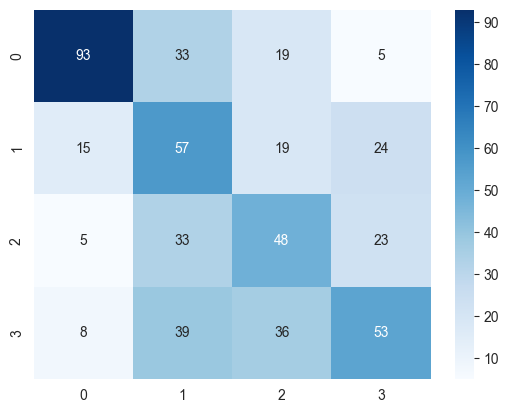

In [172]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

clf = RandomForestClassifier(n_estimators=10, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train_emotion)

y_pred = clf.predict(X_test)
print(classification_report(y_test_emotion, y_pred))
cm = confusion_matrix(y_test_emotion, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues')

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

       angry       0.77      0.59      0.66       150
       happy       0.28      0.71      0.40       115
     relaxed       0.28      0.09      0.14       109
         sad       0.48      0.24      0.32       136

    accuracy                           0.42       510
   macro avg       0.45      0.41      0.38       510
weighted avg       0.48      0.42      0.40       510



<Axes: >

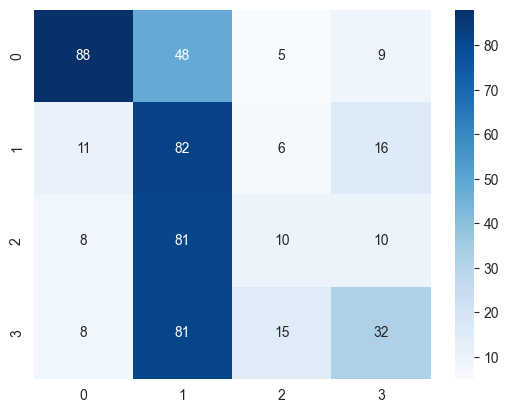

In [173]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

clf = KNeighborsClassifier(n_neighbors=200)
clf.fit(X_train, y_train_emotion)

y_pred = clf.predict(X_test)
print(classification_report(y_test_emotion, y_pred))
cm = confusion_matrix(y_test_emotion, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')